In [1]:
import cobra
from cobra.io import load_model, load_yaml_model

In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import math
import matplotlib.pyplot as plt
import copy

### Single solution

In [4]:
model = load_yaml_model("fba/yeast-GEM.yml")

In [17]:
solution = model.optimize()
df_solution = pd.DataFrame(solution.fluxes)
df_solution = df_solution.sort_index()

In [12]:
fva_result_glucose = cobra.flux_analysis.flux_variability_analysis(model)

In [ ]:
# find reactions and 

In [19]:
in_name_one = 'glucose'
in_name_two = 'transport'
for i in model.reactions:
    if in_name_one in i.name.lower() and in_name_two in i.name.lower():
        print(i)
        print(i.name)
        print('-----------------')

r_1166: s_0565 --> s_0563
glucose transport
-----------------
r_1805: s_0563 <=> s_0566
glucose transport, vacuolar
-----------------
r_4446: s_4145 <=> s_0567
D-glucose 1-phosphate transport via diffusion
-----------------
r_4453: s_4150 <=> s_0568
D-glucose 6-phosphate transport
-----------------
r_4627: s_1543 <=> s_4015
UDP-D-glucose transport
-----------------


In [29]:
glucose_transport_reaction = 'r_1166' # glucose transport
galactose_transport_reaction = 'r_1135' # galactose transport
glycerol_transport_reaction = 'r_1171' # glycerol transport
fructose_transport_reaction = 'r_1134' # fructose transport
mannose_transport_reaction = 'r_1139' # mannose transport
maltose_transport_reaction = 'r_1227' # maltose transport

In [ ]:
exchange_reactions = [
    'r_1714', #glucose
    'r_1106', #maltose
    'r_1710', #galactose
    'r_1715', #mannose
    'r_1709', #fructose
    'r_1808', #glycerol
]

In [45]:
model_change_carbon_source = model.copy()

In [39]:
# Change the yest model to use Maltose instead of Glucose in its enviroment
model_change_carbon_source.reactions.get_by_id(exchange_reactions[0]).lower_bound = 0
model_change_carbon_source.reactions.get_by_id(exchange_reactions[0]).upper_bound = 0

model_change_carbon_source.reactions.get_by_id(exchange_reactions[1]).lower_bound = 1.0
model_change_carbon_source.reactions.get_by_id(exchange_reactions[1]).upper_bound = 1000.0

solution = model_change_carbon_source.optimize()
df_solution = pd.DataFrame(solution.fluxes)
df_solution = df_solution.sort_index()

In [61]:
array = df_solution['fluxes'].to_numpy()
n = math.ceil(math.sqrt(len(df_solution.fluxes)))
# Because we want the model not to have any missing values (perfect square) 
# we fill in the missing values with NaN
padded_array = np.pad(
    df_solution['fluxes'], 
    (0, n**2 - len(df_solution.fluxes)), 
    mode='constant', 
    constant_values=np.nan
)
matrix = padded_array.reshape(n, n)

In [55]:
# take the natural log and replace infinite values (originally 0.0) to np.nan
matrix = np.abs(matrix)
matrix = np.log(matrix)
matrix[np.isinf(matrix)] = np.nan

/var/folders/f1/0h019h457jj5hb85pg_c65340000gp/T/ipykernel_16524/3836013110.py:3: RuntimeWarning: divide by zero encountered in log
  matrix = np.log(matrix)


In [63]:
matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,  1.70476692e-02,  6.87260150e-07,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,  0.00000000e+00,  0.00000000e+00,  8.79719315e-03],
       [ 1.12162599e-02,  1.12162599e-02,  5.67078280e-03, ..., -1.08369978e-01,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,             nan,             nan,             nan],
       [            nan,             nan,             nan, ...,             nan,             nan,             nan]])

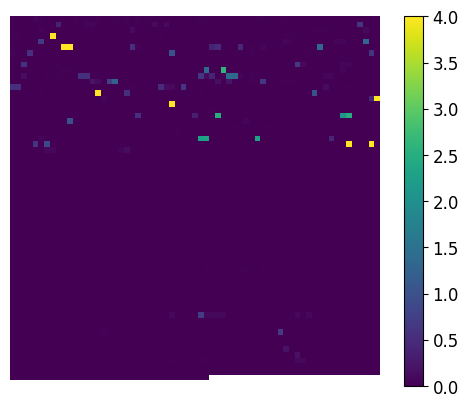

In [62]:
plt.imshow(np.abs(matrix), vmin=0, vmax=4, cmap='viridis')  # 'cmap' defines the color map
plt.axis('off')  # Turn off axis labels
#plt.savefig('images/glucose.png', bbox_inches='tight', pad_inches=0)  # Save the image
plt.colorbar()
plt.show()  # Display the image

### All carbon solutions solutions

In [5]:
#already_ran = {}
model_change_carbon_source = model.copy()

In [6]:
exchange_reactions = [
    'r_1714', #glucose
    'r_1106', #maltose
    'r_1710', #galactose
    'r_1715', #mannose
    'r_1709', #fructose
    'r_1808', #glycerol
]

In [7]:
exchange_reactions_names = {
     'r_1714': 'glucose',
    'r_1106': 'maltose',
    'r_1710': 'galactose',
    'r_1715': 'mannose',
    'r_1709': 'fructose',
    'r_1808': 'glycerol',
}

In [13]:
old_carbon_reac = None
old_carbon_reac_min = None
old_carbon_reac_max = None
old_reac = None
old_reac_min = None
old_reac_max = None
for exchange_reaction in exchange_reactions:
    #print('--> '+str(exchange_reaction))
    path_name = 'fba/images/'+exchange_reactions_names[exchange_reaction]
    if not os.path.exists(path_name):
        os.mkdir(path_name)
    #model_change_carbon_source = model.copy()
    #shutdown the glucose reaction
    if exchange_reaction!='r_1714':
        model_change_carbon_source.reactions.get_by_id('r_1714').lower_bound = 0
        model_change_carbon_source.reactions.get_by_id('r_1714').upper_bound = 0
    if old_carbon_reac_min and old_carbon_reac_max:
        if old_carbon_reac_min<=old_carbon_reac_max:
            model_change_carbon_source.reactions.get_by_id(old_carbon_reac).bounds = old_carbon_reac_min, old_carbon_reac_max
        else:
            model_change_carbon_source.reactions.get_by_id(old_carbon_reac).bounds = old_carbon_reac_max, old_carbon_reac_min
    old_carbon_reac = copy.deepcopy(exchange_reaction)
    old_carbon_reac_min = copy.deepcopy(model_change_carbon_source.reactions.get_by_id(exchange_reaction).lower_bound)
    old_carbon_reac_max = copy.deepcopy(model_change_carbon_source.reactions.get_by_id(exchange_reaction).upper_bound)
    model_change_carbon_source.reactions.get_by_id(exchange_reaction).lower_bound = -1.0
    model_change_carbon_source.reactions.get_by_id(exchange_reaction).upper_bound = 1.0
    try:
        fva_result = cobra.flux_analysis.flux_variability_analysis(model_change_carbon_source)
    except Exception as e:
        fva_result = copy.deepcopy(fva_result_glucose)
    fva_result_not_equal = fva_result[fva_result.minimum!=fva_result.maximum]
    ignore_reacs = ['r_1714', exchange_reaction]
    for reac in fva_result_not_equal.index:
        if reac not in ignore_reacs:
            #print('\t--> '+str(reac))
            for min_max in ['minimum', 'maximum']:
                #print('\t\t--> '+str(min_max))
                img_name = os.path.join(path_name, str(reac)+'_'+str(min_max)+'.png')
                if os.path.exists(img_name):
                    continue
                if old_reac_min and old_reac_max:
                    if old_reac_min<=old_reac_max:
                        model_change_carbon_source.reactions.get_by_id(old_reac).bounds = old_reac_min, old_reac_max
                    else:
                        model_change_carbon_source.reactions.get_by_id(old_reac).bounds = old_reac_max, old_reac_min
                #model_change_carbon_source_fva_reac = model_change_carbon_source.copy()
                old_reac = copy.deepcopy(reac)
                old_reac_min = copy.deepcopy(model_change_carbon_source.reactions.get_by_id(reac).lower_bound)
                old_reac_max = copy.deepcopy(model_change_carbon_source.reactions.get_by_id(reac).upper_bound)
                model_change_carbon_source.reactions.get_by_id(reac).bounds = fva_result_not_equal.loc[reac][min_max], fva_result_not_equal.loc[reac][min_max]
                # generate the solution
                solution = model_change_carbon_source.optimize()
                df_solution = pd.DataFrame(solution.fluxes)
                df_solution = df_solution.sort_index()
                # make the image
                array = df_solution['fluxes'].to_numpy()
                n = math.ceil(math.sqrt(len(df_solution.fluxes)))
                padded_array = np.pad(df_solution['fluxes'], (0, n**2 - len(df_solution.fluxes)), mode='constant', constant_values=np.nan)
                matrix = padded_array.reshape(n, n)
                matrix = np.log(matrix)
                matrix[np.isinf(matrix)] = np.nan
                plt.imshow(matrix, cmap='viridis')  # 'cmap' defines the color map
                plt.axis('off')  # Turn off axis labels
                plt.savefig(img_name, bbox_inches='tight', pad_inches=0)  # Save the image
                plt.close()

/Users/mel/miniconda3/envs/fastbook/lib/python3.11/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/var/folders/f1/0h019h457jj5hb85pg_c65340000gp/T/ipykernel_16524/3678202068.py:60: RuntimeWarning: divide by zero encountered in log
  matrix = np.log(matrix)
/var/folders/f1/0h019h457jj5hb85pg_c65340000gp/T/ipykernel_16524/3678202068.py:60: RuntimeWarning: invalid value encountered in log
  matrix = np.log(matrix)


In [14]:
fns = get_image_files('fba/images/')

In [15]:
#failed = verify_images(fns)

In [16]:
#failed

In [17]:
fba_models = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128), 
)

In [18]:
dls = fba_models.dataloaders(os.path.join(os.getcwd(), 'fba/images/'), device=torch.device('cpu'))

In [19]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

/Users/mel/miniconda3/envs/fastbook/lib/python3.11/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


In [20]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.049675,0.032455,0.014334,21:31


epoch,train_loss,valid_loss,error_rate,time
0,0.046090,0.027153,0.014583,56:49
1,0.025084,0.022025,0.012340,4:38:23


In [21]:
learn.export()

In [ ]:
## explore the results

In [11]:
#learn = load_learner('export.pkl')

/Users/mel/miniconda3/envs/fastbook/lib/python3.11/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


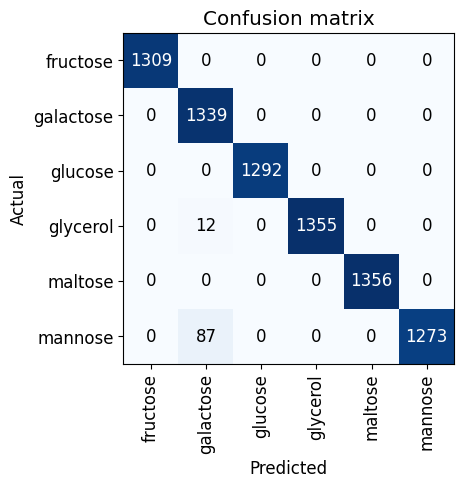

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [24]:
learn.predict('fba/images/galactose/r_0001_maximum.png')

/Users/mel/miniconda3/envs/fastbook/lib/python3.11/site-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


('galactose',
 tensor(1),
 tensor([2.6685e-06, 9.9991e-01, 1.9412e-07, 3.0520e-06, 7.9484e-08, 8.7688e-05]))

In [29]:
df_solution.loc[exchange_reactions]

,fluxes
r_1714,0.0
r_1106,0.0
r_1710,0.0
r_1715,0.0
r_1709,0.0
r_1808,-1.0


In [30]:
df_solution.loc[carbon_sources]

NameError: name 'carbon_sources' is not defined

### Read the model XML file

In [20]:
tree = ET.parse('tools/sce01100.xml')

In [21]:
# if the color of the node is #80CCCC

In [91]:
root = tree.getroot()
res = {}
cs_bg = []
cs_fg = []
for child in root:
    if child.attrib['type']=='gene':
        g = child.find('graphics')
        print(g.attrib)
        if g.attrib['bgcolor'] not in cs_bg:
            cs_bg.append(g.attrib['bgcolor'])
        if g.attrib['fgcolor'] not in cs_fg:
            cs_fg.append(g.attrib['fgcolor'])
        if g.attrib['fgcolor']=='#80CCCC':
            res[g.attrib['name']] = {'x': g.attrib['x'], 'y': g.attrib['y']}

{'name': 'SHM1, SHMT1, TMP3...', 'fgcolor': '#FFCC66', 'bgcolor': '#FFFFFF', 'type': 'line', 'coords': '1936,2049,1936,1692,1936,1692,1936,1689,1937,1687,1938,1684,1940,1682,1942,1680,1944,1678,1947,1677,1949,1676,1952,1676,1952,1676,2340,1676,2340,1676,2343,1676,2346,1676,2350,1676,2354,1676,2358,1676,2362,1676,2366,1676,2369,1676,2372,1676,2372,1676,2969,1676,2969,1676,2972,1676,2974,1677,2977,1678,2979,1680,2981,1682,2983,1684,2984,1687,2985,1689,2985,1692,2985,1692,2985,1697,2985,1697,2985,1700,2986,1702,2987,1705,2989,1707,2991,1709,2993,1711,2996,1712,2998,1713,3001,1713,3001,1713,3093,1713'}
{'name': 'DFG10', 'fgcolor': '#80CCCC', 'bgcolor': '#FFFFFF', 'type': 'line', 'coords': '1087,2348,1087,2406,1087,2406,1087,2409,1088,2411,1089,2414,1091,2416,1093,2418,1095,2420,1098,2421,1100,2422,1103,2422,1103,2422,1133,2422'}


KeyError: 'x'

In [82]:
res

{}

In [87]:
array = df['column_to_matrix'].to_numpy()

# Reshape the array into a matrix (e.g., 2x3 matrix)
matrix = array.reshape(2, 3)

['#E0E0E0', '#FFFFFF']

In [88]:
cs_fg

['#E0E0E0', '#FFCC66', '#80CCCC']

In [68]:
child = root[10]

In [69]:
child.attrib['name']

'cpd:C06377'

In [70]:
g = child.find('graphics')

In [73]:
g.attrib['fgcolor']

'#E0E0E0'

In [35]:
for child in root:
    print(child.tag)
    print(child.attrib)
    print(child.text)
    print('------')

entry
{'id': '7888', 'name': 'cpd:C03852', 'type': 'compound', 'link': 'https://www.kegg.jp/dbget-bin/www_bget?C03852'}

        
------
entry
{'id': '7887', 'name': 'cpd:C18041', 'type': 'compound', 'link': 'https://www.kegg.jp/dbget-bin/www_bget?C18041'}

        
------
entry
{'id': '7886', 'name': 'cpd:C18042', 'type': 'compound', 'link': 'https://www.kegg.jp/dbget-bin/www_bget?C18042'}

        
------
entry
{'id': '7885', 'name': 'cpd:C22832', 'type': 'compound', 'link': 'https://www.kegg.jp/dbget-bin/www_bget?C22832'}

        
------
entry
{'id': '7884', 'name': 'cpd:C13712', 'type': 'compound', 'link': 'https://www.kegg.jp/dbget-bin/www_bget?C13712'}

        
------
entry
{'id': '7883', 'name': 'cpd:C22831', 'type': 'compound', 'link': 'https://www.kegg.jp/dbget-bin/www_bget?C22831'}

        
------
entry
{'id': '6243', 'name': 'cpd:C16583', 'type': 'compound', 'link': 'https://www.kegg.jp/dbget-bin/www_bget?C16583'}

        
------
entry
{'id': '5724', 'name': 'cpd:C20581'